In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# set random seeds for reproducibility
torch.manual_seed(42)

In [3]:
# 1. Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
df = pd.read_csv("fashion-mnist_test.csv")

In [5]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
y=df.iloc[:, 0].values # Target
X=df.iloc[:, 1:].values # Feature1, Feature2

In [7]:
print(X)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 1 3 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [8]:
print(y)

[0 1 2 ... 8 8 1]


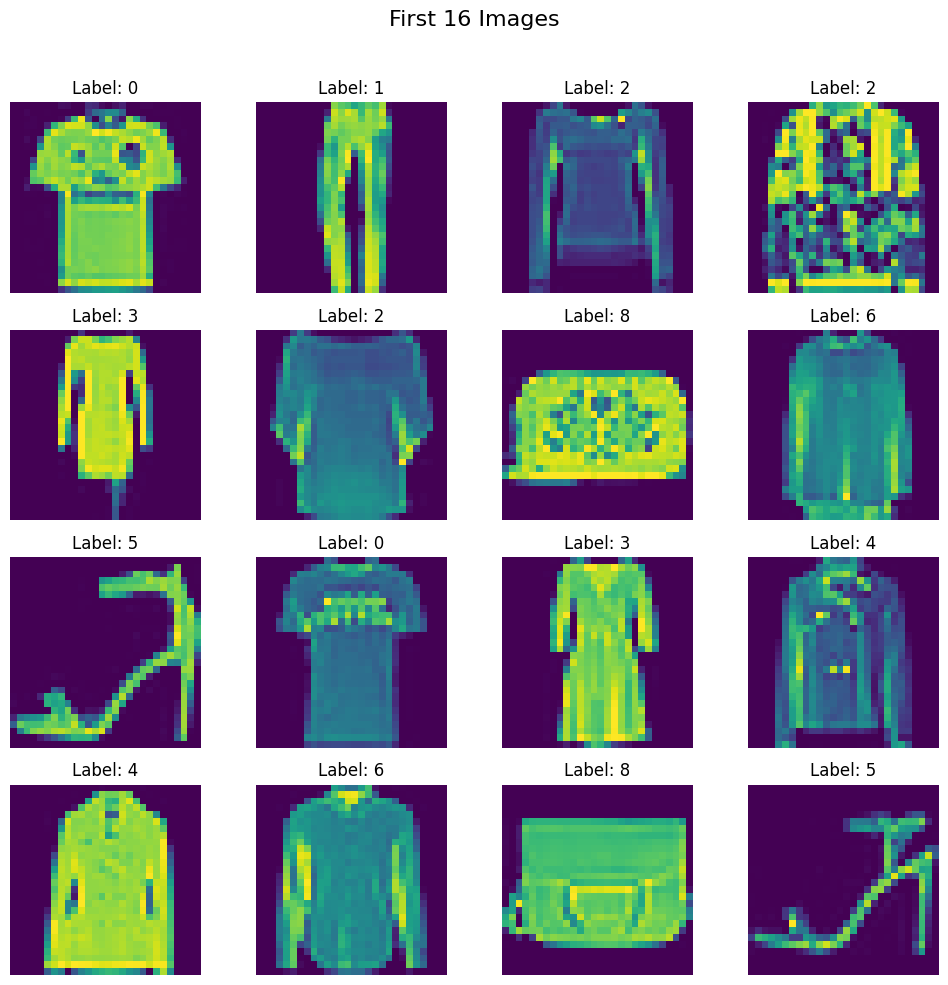

In [9]:
# Create a 4*4 grid images
fig, axes = plt.subplots(4,4,figsize=(10,10))
fig.suptitle("First 16 Images",fontsize=16)

# Plot the first 16 images from the dataset

for i, ax in enumerate(axes.flat):
  img = df.iloc[i,1:].values.reshape(28,28) # reshape to 28*28
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f"Label: {df.iloc[i,0]}") # show label

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [11]:
X_train

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ..., 115,  35,   0],
       [  0,   0,   0, ...,   0,   0,   0]])

In [12]:
# transformation

from torchvision.transforms import transforms

custom_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    ])

In [13]:
from PIL import  Image
import numpy as np


In [14]:
# create dataset
class CustomDataset(Dataset):

  def __init__(self,features,labels, transform) -> None:
    self.features = features
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    # resize (28,28)
    image = self.features[index].reshape(28,28)
    # change datatype np.uint8
    image = image.astype(np.uint8)
    # balck & whote to color
    image = np.stack([image]*3,axis=-1)
    # convert array to PIL images
    image = Image.fromarray(image)
    # apply transform
    image = self.transform(image)

    return image,torch.tensor(self.labels[index],dtype=torch.long)


In [15]:
train_dataset = CustomDataset(X_train,y_train,transform=custom_transformer)
test_dataset = CustomDataset(X_test,y_test,transform=custom_transformer)

In [16]:
train_loader = DataLoader(train_dataset,batch_size=128, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset,batch_size=128, shuffle=False, pin_memory=True)

In [17]:
len(train_loader)

63

In [18]:
# fetch pretrain model
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
vgg16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [21]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [22]:
# freez weights for features
for param in vgg16.features:
  param.requires_grad = False

In [23]:
vgg16.classifier = nn.Sequential(
    nn.Linear(25088,1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(1024,512),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512,10),
)

In [24]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=512, out_features=10, bias=True)
)

In [25]:
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [26]:
learning_rate = 0.0001
epochs = 1

In [27]:
# loss function
criterion = nn.CrossEntropyLoss()

In [28]:
# optimizer
#optimizer = optim.SGD(model.parameters(),lr=learning_rate) #optimization without using Regularization L2

optimizer = optim.Adam(vgg16.classifier.parameters(),lr=learning_rate) #optimization using Regularization L2

In [29]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    # forward pass
    y_pred = vgg16(batch_features)

    print(y_pred.shape)
    print(batch_labels.shape)

    # loss
    loss = criterion(y_pred,batch_labels)
    # back pass
    optimizer.zero_grad()
    loss.backward()
    # update grads
    optimizer.step()

    total_epoch_loss +=loss.item()
    #break

  avg_loss = total_epoch_loss/len(train_loader)
  print(f"Avg loss : {avg_loss} epoch : {epoch + 1}")


torch.Size([128, 10])
torch.Size([128])
Avg loss : 0.0367445983583965 epoch : 1


In [30]:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Test Accuracy
total = 0
correct = 0

with torch.no_grad():
  for batch_features,batch_labels in test_loader:
    batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)
    outputs = vgg16(batch_features)

    _, predicted = torch.max(outputs,1)

    total += batch_features.shape[0]

    correct += (predicted == batch_labels).sum().item()

print(f"Test Accuracy : {correct/total}")

Test Accuracy : 0.4215


In [ ]:
# Train Accuracy
total = 0
correct = 0

with torch.no_grad():
  for batch_features,batch_labels in train_loader:
    batch_features,batch_labels = batch_features.to(device),batch_labels.to(device)
    outputs = vgg16(batch_features)

    _, predicted = torch.max(outputs,1)

    total += batch_features.shape[0]

    correct += (predicted == batch_labels).sum().item()

print(f"Train Accuracy : {correct/total}")

##Optimize
#Dropout
- Simplified Neural Network
- at hidden layer
- after ReLU
- not used at evalaution

#Regularization
-

#Batch Normalization